In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
# importing standard packages
import os
import sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# importing 3rd party packages
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# importing local packages
from src import class_Cleaner as c
from src import class_Database as d
from src import class_Harness as h
from src import helper_functions as f
from src import visualizations as v

# setting style
%matplotlib inline
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

time: 2.97 s


## Creating the Database and Instantiating a Database Object

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.31 ms


## Populating the Database

**If necessary, run the cell below to populate the database.**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 462 µs


## Instantiating a Cleaner Object

In [5]:
cl = c.Cleaner(database_name)

time: 1.41 ms


## Preprocessing and Harness Objects
Creating column selectors, transformers, scorers, and a SMOTE instance for the pipeline. Also, instantiating a harness object to record the modeling process.

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
sm = SMOTE(random_state=2021)

# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.9 ms


## Half Term Data

In order to be able to predict unsatisfactory outcomes while there is still time to intervene, we limited the model to data logged upto the halfway of the courses. Since the median course length is 240 days, a cutoff point of 120 days was chosen. Further, students who withdrew before the 120th day were dropped from the data, since their outcome was fully determined within the 120 day window.

The data was collected into an SQL database, and a data frame was constructed from the various database tables. During the creation process, the multiclass `final_result` feature was binarized into a `target` feature with classes Satisfactory (Pass, Distinction), and Unsatisfactory (Withdrawn, Fail). A `row_id` feature was constructed to identify unique student-course-semester combinations, and a `sum_activity` feature was added to quantify the level of a student's interaction with the course material. Lastly, `weighted_ave`,  `mean_score`, and `median_score` were derived from the each row's  assessment data. 

In [7]:
df = cl.data_prep_half(120)

time: 9.94 s


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24770 entries, 0 to 24769
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target                23261 non-null  float64
 1   row_id                24770 non-null  object 
 2   score                 23237 non-null  object 
 3   gender                23261 non-null  object 
 4   region                23261 non-null  object 
 5   highest_education     23261 non-null  object 
 6   imd_band              22335 non-null  object 
 7   age_band              23261 non-null  object 
 8   num_of_prev_attempts  23261 non-null  float64
 9   studied_credits       23261 non-null  float64
 10  disability            23261 non-null  object 
 11  final_result          23261 non-null  object 
 12  date_sub              23261 non-null  float64
 13  course_length         23261 non-null  float64
 14  weighted_ave          23255 non-null  float64
 15  mean_score         

## Data Preparation

In [9]:
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration', 'max_date', 'code_presentation',
         'id_student', 'activity_level']

time: 928 µs


In [10]:
df = cl.pipe_cleaner_wa(df, drops).reset_index(drop=True)

time: 91.4 ms


After the data frame was created various cosmetic fixes were applied to the data, and outliers were dropped from the `studied_credits`, `weighted_ave`, and `sum_activity` features using IQR fences. A categorical `course_load` feature was derived by binning `studied_credits`, and a categorical `activity_level` feature was created by binning `sum_activity`. The `course_load` feature was used during the modeling process, and `activity_level` was used for statistical testing when while investigating business recommendations. Lastly, null values and extraneous columns were dropped in preparation of the modeling process.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19458 entries, 0 to 19457
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                19458 non-null  float64 
 1   gender                19458 non-null  object  
 2   region                19458 non-null  object  
 3   highest_education     19458 non-null  object  
 4   imd_band              19458 non-null  object  
 5   age_band              19458 non-null  object  
 6   num_of_prev_attempts  19458 non-null  float64 
 7   disability            19458 non-null  object  
 8   weighted_ave          19458 non-null  float64 
 9   mean_score            19458 non-null  float64 
 10  median_score          19458 non-null  float64 
 11  code_module           19458 non-null  object  
 12  sum_activity          19458 non-null  float64 
 13  course_load           19458 non-null  category
dtypes: category(1), float64(6), object(7)
memory usage: 1.

## Features Used

The following features will be used in the modeling process:
    
-  gender: The gender of the student.    
-  region: The geographic region of the student.   
- highest_education: The education level of the student.   
- imd_band: A measure of economic status based on geographic location.   
- age_band: The age cohort of the student.   
- num_of_prev_attempts: The number of times the student has attempted the class.   
- disability: The disability status of the student.
- weighted_ave: The weighted average of the student's assessment scores.
- mean_score: The student's mean assessment score.
- median_score: The student's median assessment score.
- sum_activity: The sum of the activities, and the number of clicks for each activity, that the student logged.
- code_module: The three letter code of the course.
- course_load: A three level categorization of the total credits the student was enrolled in at the time of the course.
    

## Summary Statistics for the Numerical Features

In [12]:
df.describe()

,target,num_of_prev_attempts,weighted_ave,mean_score,median_score,sum_activity
count,19458.000000,19458.000000,19458.000000,19458.000000,19458.000000,19458.000000
mean,0.359595,0.140713,106.436972,74.288758,74.583256,901.266780
std,0.479894,0.449925,65.628103,15.207932,15.078946,724.074213
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,60.800000,66.400000,66.500000,345.000000
50%,0.000000,0.000000,113.020000,77.400000,77.500000,694.000000
75%,1.000000,0.000000,152.000000,85.000000,85.000000,1268.750000
max,1.000000,6.000000,299.920000,100.000000,100.000000,3179.000000


time: 29.8 ms


## Creating Holdout Data

In [13]:
# splitting data & target
X, y = f.X_y(df)

time: 3 ms


In [14]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 10.9 ms


## Creating Training Data

In [15]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 8.58 ms


In [16]:
df.target.value_counts(normalize=True)

0.0    0.640405
1.0    0.359595
Name: target, dtype: float64

time: 4.23 ms


# Modeling

Since we want to indentify as many unsatisfactory outcomes possible while still minimizing false positives, we will use F1 as the metric of our models.

## Baseline Model: Dummy Classifier
The classifier will predict the minority class for each observation.

In [17]:
dummy = DummyClassifier(strategy='constant', constant=1)

time: 718 µs


In [18]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 721 µs


### Fitting Model

In [19]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>)])),
                ('dummyclassifier',
                 DummyClassifier(constant=1, strategy='constant'))])

time: 79.9 ms


### Saving Model

In [20]:
# f.pickle_model(baseline, 'baseline')

time: 462 µs


### Cross Val Scores

In [21]:
modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.3596491264699766
 Baseline has an average F1 of 0.5290322368027472
 Baseline has an average Recall of 1.0
 Baseline has an average Precision of 0.3596491264699766
time: 186 ms


### Test Data Confusion Matrix

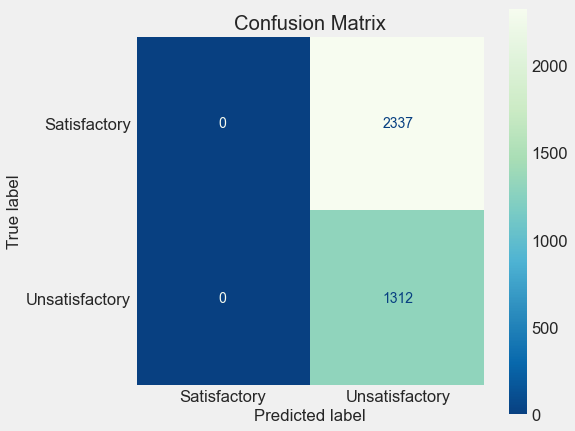

,Accuracy,F1,Recall,Precision
0,0.359551,0.528926,1.0,0.359551


time: 222 ms


In [22]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test)

## Score Interpretation:

F1 is a mix of both precision and recall, so the interpretation of the results is more easily given in terms of recall and precision.

- From the confusion matrix we see that the baseline model is classifying everything as the minority class, which was expected.
- All Unsatisfactory outcomes were correctly classified as Unsatisfactory, so the recall score for this model is 1. 
- The precision score of .36 indicates that 36% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

## First Simple Model: Naive Bayes Classifier
We will use a basic classifier for our first simple model.

In [23]:
mnb = MultinomialNB()

time: 640 µs


In [24]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 723 µs


### Fitting Model

In [25]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>)])),
                ('multinomialnb', MultinomialNB())])

time: 36.8 ms


### Saving Model

In [26]:
# f.pickle_model(fsm, 'fsm')

time: 496 µs


### Cross Val Scores

In [27]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.6565241864967183
 fsm has an average F1 of 0.34631062761486303
 fsm has an average Recall of 0.2530466527776882
 fsm has an average Precision of 0.5493400673472756
time: 202 ms


### Test Data Confusion Matrix

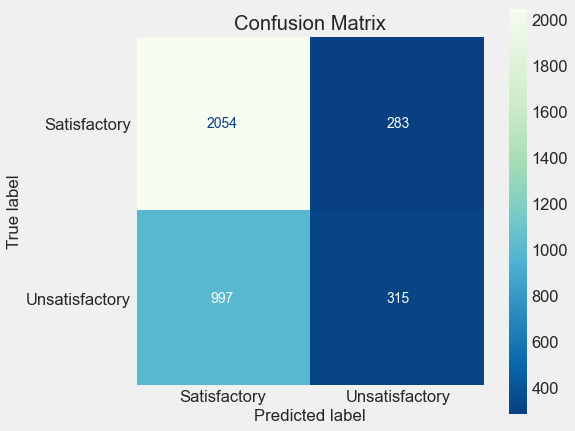

,Accuracy,F1,Recall,Precision
0,0.649219,0.329843,0.240091,0.526756


time: 190 ms


In [28]:
f.confusion_report(fsm, X_test, y_test)

## Score Interpretation:

- From the confusion matrix we see that the fsm model is classifying outcomes slightly better than baseline.
- The recall score of .24 indicates that about 19% outcomes were correctly classified as Unsatisfactory. 
- The precision score .53 indicates that about 53% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

# Standard Scaling
Since a few of the numerical features differ by orders of magnitude, standard scaling will be implemented to aid in model convergence and performance.

## KNeighborsClassifier

In [29]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 687 µs


In [30]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 637 µs


### Fitting Model

In [31]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103fc2ee0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 50.1 ms


In [32]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 520 µs


### Cross Val Scores

In [33]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.7414098496471054
knn_ss has an average F1 of 0.6004264245619517
knn_ss has an average Recall of 0.5403995123807559
knn_ss has an average Precision of 0.6760609302498518
time: 3.62 s


### Test Data Confusion Matrix

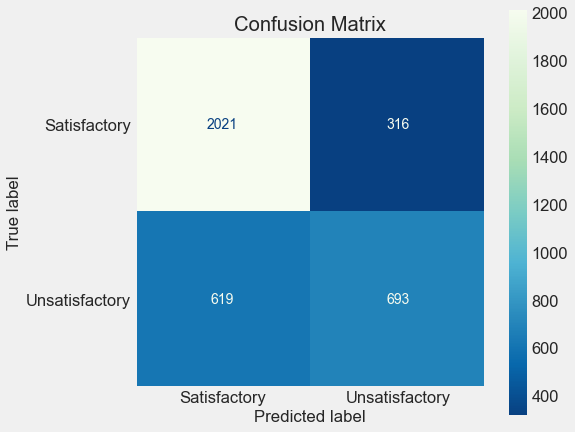

,Accuracy,F1,Recall,Precision
0,0.743765,0.597156,0.528201,0.686819


time: 7.42 s


In [34]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [35]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 729 µs


In [36]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 751 µs


### Fitting Model

In [37]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103fc2ee0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 4.49 s


### Cross Val Scores

In [38]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7680917049933063
logreg_ss has an average F1 of 0.6372880548224862
logreg_ss has an average Recall of 0.5668202839285599
logreg_ss has an average Precision of 0.728208528619641
time: 4.96 s


### Test Data Confusion Matrix

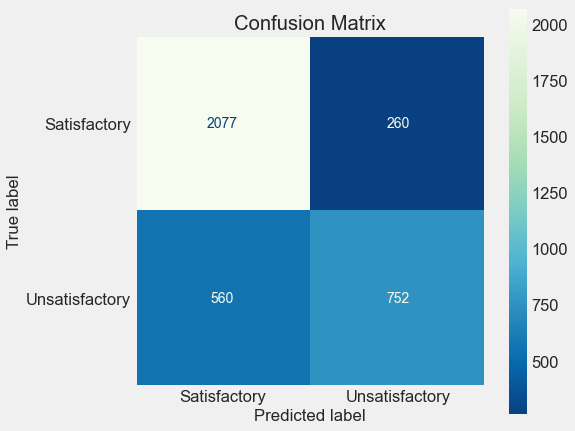

,Accuracy,F1,Recall,Precision
0,0.775281,0.64716,0.573171,0.743083


time: 202 ms


In [39]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [40]:
SVC = SVC()

time: 599 µs


In [41]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 914 µs


### Fitting Model

In [42]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103fc2ee0>)])),
                ('svc', SVC())])

time: 4.77 s


### Cross Val Scores

In [43]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.7855441408471642
svc_ss has an average F1 of 0.6519967733529908
svc_ss has an average Recall of 0.5589416211404873
svc_ss has an average Precision of 0.7826606735757377
time: 19.6 s


### Test Data Confusion Matrix

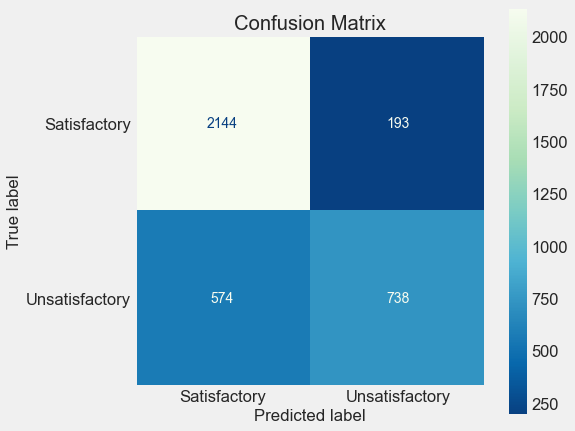

,Accuracy,F1,Recall,Precision
0,0.789805,0.658047,0.5625,0.792696


time: 5.79 s


In [44]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [45]:
LSVC = LinearSVC(random_state=2021)

time: 606 µs


In [46]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 832 µs


### Fitting Model

In [47]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103fc2ee0>)])),
                ('linearsvc', LinearSVC(random_state=2021))])

time: 707 ms


### Cross Val Scores

In [48]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7680917049933061
lsvc_ss has an average F1 of 0.6340618805158209
lsvc_ss has an average Recall of 0.5589442011364882
lsvc_ss has an average Precision of 0.7329679790281349
time: 2.43 s


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Test Data Confusion Matrix

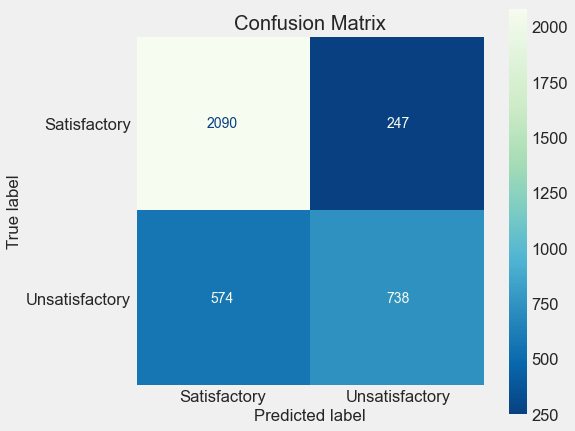

,Accuracy,F1,Recall,Precision
0,0.775007,0.642577,0.5625,0.749239


time: 212 ms


In [49]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [50]:
DT = DecisionTreeClassifier(random_state=2021)

time: 636 µs


In [51]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 766 µs


### Fitting Model

In [52]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103fc2ee0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 445 ms


### Cross Val Scores

In [53]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.7148213645926157
dt_ss has an average F1 of 0.6056545119605301
dt_ss has an average Recall of 0.609246060668606
dt_ss has an average Precision of 0.6022543448277029
time: 1.65 s


### Test Data Confusion Matrix

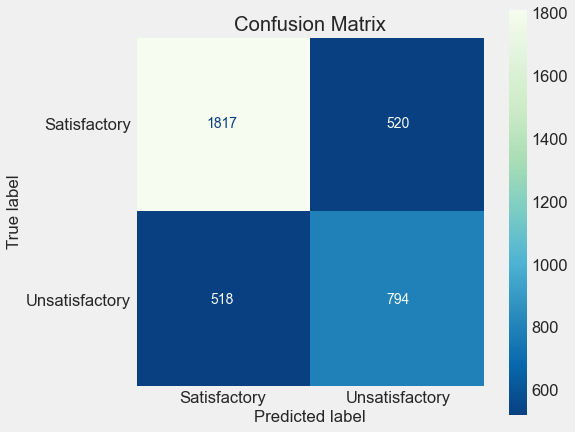

,Accuracy,F1,Recall,Precision
0,0.715539,0.604722,0.605183,0.604262


time: 222 ms


In [54]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [55]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 662 µs


In [56]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 954 µs


### Fitting Model

In [57]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103fc2ee0>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.78 s


### Cross Val Scores

In [58]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.7678177325049713
bclf_ss has an average F1 of 0.6346910956307087
bclf_ss has an average Recall of 0.5612249176013777
bclf_ss has an average Precision of 0.7307342436661142
time: 10.2 s


### Test Data Confusion Matrix

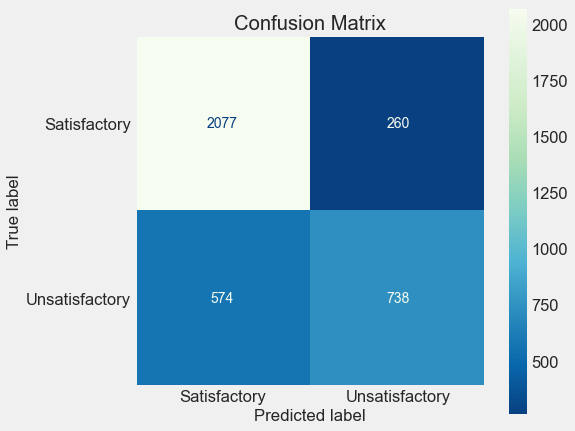

,Accuracy,F1,Recall,Precision
0,0.771444,0.638961,0.5625,0.739479


time: 269 ms


In [59]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [60]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 699 µs


In [61]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 735 µs


### Fitting Model

In [62]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103fc2ee0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 1.79 s


### Cross Val Scores

In [63]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.7782348672062323
rf_ss has an average F1 of 0.6552371168495934
rf_ss has an average Recall of 0.5863811686091885
rf_ss has an average Precision of 0.7430118917459738
time: 9.28 s


### Test Data Confusion Matrix

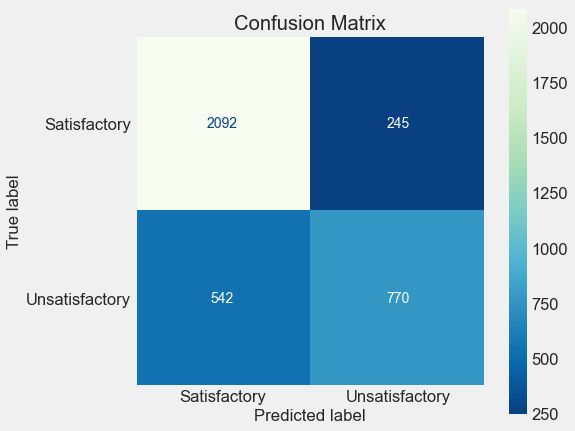

,Accuracy,F1,Recall,Precision
0,0.784324,0.661796,0.58689,0.758621


time: 455 ms


In [64]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [65]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 660 µs


In [66]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 921 µs


### Fitting Model

In [67]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103fc2ee0>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 494 ms


### Cross Val Scores

In [68]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.7185668244830602
ada_ss has an average F1 of 0.6098888181481925
ada_ss has an average Recall of 0.6120401963376957
ada_ss has an average Precision of 0.6079263780906887
time: 1.85 s


### Test Data Confusion Matrix

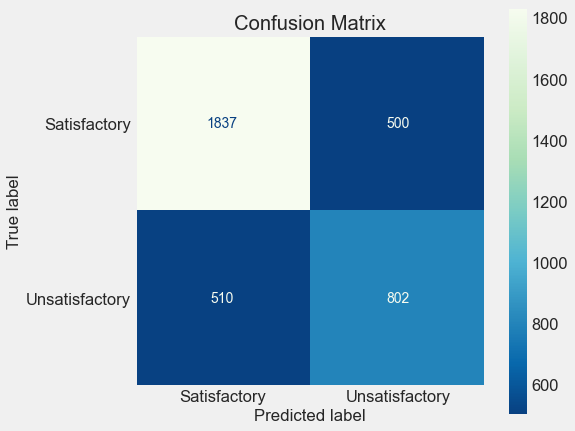

,Accuracy,F1,Recall,Precision
0,0.723212,0.613619,0.61128,0.615975


time: 218 ms


In [69]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [70]:
XGB = XGBClassifier(use_label_encoder=False, verbosity=0)

time: 693 µs


In [71]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 850 µs


### Fitting Model

In [72]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103fc2ee0>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 693 ms


### Cross Val Scores

In [73]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

time: 3.18 s


### Test Data Confusion Matrix

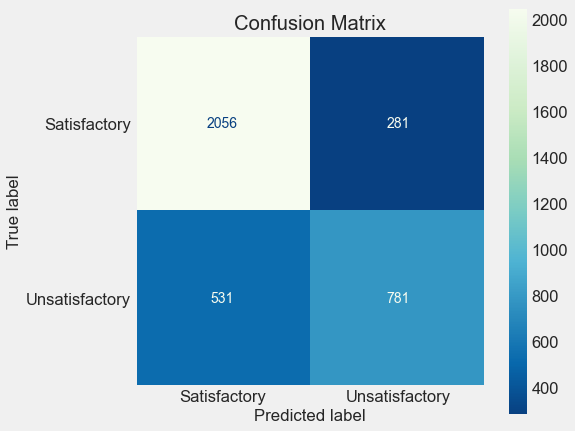

,Accuracy,F1,Recall,Precision
0,0.777473,0.657961,0.595274,0.735405


time: 423 ms


In [74]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary

In [75]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,fsm,0.656524,0.346311,0.253047,0.549340,0.199047,FSM Naive Bayes
1,Baseline,0.359649,0.529032,1.000000,0.359649,0.183302,Baseline DummyCFL
2,knn_ss,0.741410,0.600426,0.540400,0.676061,3.616009,KNN SS()
3,dt_ss,0.714821,0.605655,0.609246,0.602254,1.649509,Decision Tree CLF SS()
4,ada_ss,0.718567,0.609889,0.612040,0.607926,1.844192,AdaBoost SS()
5,lsvc_ss,0.768092,0.634062,0.558944,0.732968,2.424637,Linear SVC SS()
6,bclf_ss,0.767818,0.634691,0.561225,0.730734,10.177706,Bagging CLF SS()
7,logreg_ss,0.768092,0.637288,0.566820,0.728209,4.954445,LogReg SS()
8,svc_ss,0.785544,0.651997,0.558942,0.782661,19.619819,Support Vector CLF SS()
9,rf_ss,0.778235,0.655237,0.586381,0.743012,9.274697,Random Forest SS()


time: 10.7 ms


## Voting Classifier (BCLF, RF, XGBoost)
I found that the combination of these three models had the best mix of speed and performance.

In [76]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

time: 1.09 ms


In [77]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 836 µs


### Fitting Model

In [78]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103fc2ee0>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.46 s


### Cross Val Scores

In [79]:
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

vc_ss has an average Accuracy of 0.7841746959828226
vc_ss has an average F1 of 0.6683049117688185
vc_ss has an average Recall of 0.605181921968021
vc_ss has an average Precision of 0.7467725174879198
time: 19.1 s


In [80]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,fsm,0.656524,0.346311,0.253047,0.549340,0.199047,FSM Naive Bayes
1,Baseline,0.359649,0.529032,1.000000,0.359649,0.183302,Baseline DummyCFL
2,knn_ss,0.741410,0.600426,0.540400,0.676061,3.616009,KNN SS()
3,dt_ss,0.714821,0.605655,0.609246,0.602254,1.649509,Decision Tree CLF SS()
4,ada_ss,0.718567,0.609889,0.612040,0.607926,1.844192,AdaBoost SS()
5,lsvc_ss,0.768092,0.634062,0.558944,0.732968,2.424637,Linear SVC SS()
6,bclf_ss,0.767818,0.634691,0.561225,0.730734,10.177706,Bagging CLF SS()
7,logreg_ss,0.768092,0.637288,0.566820,0.728209,4.954445,LogReg SS()
8,svc_ss,0.785544,0.651997,0.558942,0.782661,19.619819,Support Vector CLF SS()
9,rf_ss,0.778235,0.655237,0.586381,0.743012,9.274697,Random Forest SS()


time: 16.6 ms


## Initial Modeling Summary

Implementation of standard scaling and more advanced algorithms has greatly improved performance, with the highest performing model achieving:

- Mean F1 = 0.67
- Mean recall = 0.61
- Mean precision = 0.75

This model is a voting classifier consisting of a bagging classifier, a random forest classifier, and and extreme boosting (XGBoost) classifier.

### Test Data Confusion Matrix

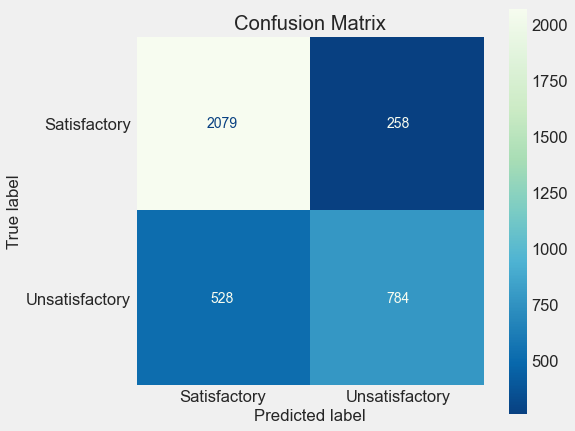

,Accuracy,F1,Recall,Precision
0,0.784599,0.6661,0.597561,0.752399


time: 700 ms


In [81]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Top Model Score Interpretation:
The confusion matrix indicates that the  voting classifier is still having trouble identifying Unsatisfactory outcomes.
- The recall score of .60 indicates that about 60% outcomes were correctly classified as Unsatisfactory. 
- The precision score .75 indicates that about 75% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

# SMOTE

In [82]:
df.target.value_counts(normalize=True)

0.0    0.640405
1.0    0.359595
Name: target, dtype: float64

time: 4.94 ms


Since the classes have an imbalance of around 2 to 1, SMOTE will be added to the pipeline in an attempt to aid model performance.

## Voting CLF SMOTE

In [83]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [ ('bclf', clf1), ('rf', clf2), ('xgb', clf3)]
VC = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

time: 1.15 ms


In [84]:
vc_sm = make_sm_pipeline(preprocessing_ss, sm, VC)

time: 890 µs


### Fitting Model

In [85]:
%%capture --no-display
vc_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x103fc2ee0>)])),
                ('smote', SMOTE(random_state=2...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
                    

time: 7.95 s


### Cross Val Scores

In [86]:
# %%capture --no-display
# checking cross val scores
modeling.report(vc_sm, X_train, y_train, 'vc_sm',\
                'Voting CLF SS()/SMOTE SOFT')

vc_sm has an average Accuracy of 0.7851789694692508
vc_sm has an average F1 of 0.6864619365297383
vc_sm has an average Recall of 0.6542186159611452
vc_sm has an average Precision of 0.7224615639644287
time: 32.8 s


## Model Summary

In [87]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,fsm,0.656524,0.346311,0.253047,0.549340,0.199047,FSM Naive Bayes
1,Baseline,0.359649,0.529032,1.000000,0.359649,0.183302,Baseline DummyCFL
2,knn_ss,0.741410,0.600426,0.540400,0.676061,3.616009,KNN SS()
3,dt_ss,0.714821,0.605655,0.609246,0.602254,1.649509,Decision Tree CLF SS()
4,ada_ss,0.718567,0.609889,0.612040,0.607926,1.844192,AdaBoost SS()
5,lsvc_ss,0.768092,0.634062,0.558944,0.732968,2.424637,Linear SVC SS()
6,bclf_ss,0.767818,0.634691,0.561225,0.730734,10.177706,Bagging CLF SS()
7,logreg_ss,0.768092,0.637288,0.566820,0.728209,4.954445,LogReg SS()
8,svc_ss,0.785544,0.651997,0.558942,0.782661,19.619819,Support Vector CLF SS()
9,rf_ss,0.778235,0.655237,0.586381,0.743012,9.274697,Random Forest SS()


time: 15.6 ms


### Test Data Confusion Matrix

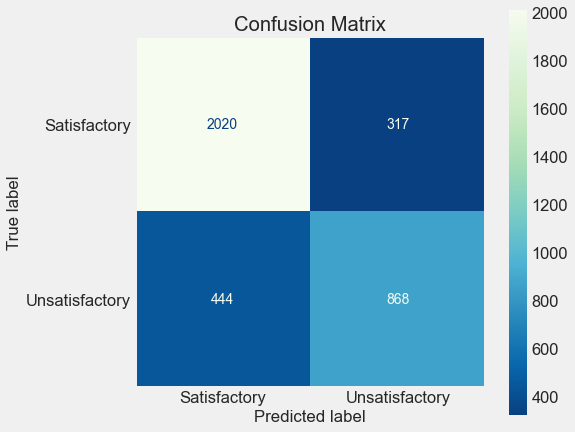

,Accuracy,F1,Recall,Precision
0,0.79145,0.695234,0.661585,0.732489


time: 831 ms


In [88]:
%%capture --no-display
f.confusion_report(vc_sm, X_test, y_test)

## Score Interpretation:

Upon validation with the test data we see that the model is still having some trouble the minority class, but recall has been improved.

- The recall score of .66 indicates that about 66% outcomes were correctly classified as Unsatisfactory.
- The precision score .73 indicates that about 73% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

# Hyperparameter Tuning

In [89]:
# getting params
vc_sm.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'smote', 'votingclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__onehotencoder', 'columntransformer__standardscaler', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'votingclassifier__estimators', 'votingclassifier__flatten_transform', 'votingclassifier__n_jobs', 'votingclassifier__verbose', 'votingclassifier__voting', 'votingclassifie

time: 3.59 ms


## Separating the Parameters by Classifier

### BCLF

In [90]:
bag_params = ['votingclassifier__bclf__base_estimator__ccp_alpha', 
              'votingclassifier__bclf__base_estimator__class_weight',
              'votingclassifier__bclf__base_estimator__criterion', 
              'votingclassifier__bclf__base_estimator__max_depth', 
              'votingclassifier__bclf__base_estimator__max_features', 
              'votingclassifier__bclf__base_estimator__max_leaf_nodes', 
              'votingclassifier__bclf__base_estimator__min_impurity_decrease', 
              'votingclassifier__bclf__base_estimator__min_impurity_split', 
              'votingclassifier__bclf__base_estimator__min_samples_leaf', 
              'votingclassifier__bclf__base_estimator__min_samples_split', 
              'votingclassifier__bclf__base_estimator__min_weight_fraction_leaf', 
              'votingclassifier__bclf__base_estimator__random_state', 
              'votingclassifier__bclf__base_estimator__splitter', 
              'votingclassifier__bclf__base_estimator', 
              'votingclassifier__bclf__bootstrap', 
              'votingclassifier__bclf__bootstrap_features', 
              'votingclassifier__bclf__max_features', 
              'votingclassifier__bclf__max_samples',
              'votingclassifier__bclf__n_estimators', 
              'votingclassifier__bclf__n_jobs', 
              'votingclassifier__bclf__oob_score', 
              'votingclassifier__bclf__random_state', 
              'votingclassifier__bclf__verbose', 
              'votingclassifier__bclf__warm_start']

time: 1.49 ms


### RF

In [91]:
rf_params = ['votingclassifier__rf__bootstrap',
             'votingclassifier__rf__ccp_alpha', 
             'votingclassifier__rf__class_weight', 
             'votingclassifier__rf__criterion', 
             'votingclassifier__rf__max_depth', 
             'votingclassifier__rf__max_features', 
             'votingclassifier__rf__max_leaf_nodes', 
             'votingclassifier__rf__max_samples', 
             'votingclassifier__rf__min_impurity_decrease', 
             'votingclassifier__rf__min_impurity_split', 
             'votingclassifier__rf__min_samples_leaf', 
             'votingclassifier__rf__min_samples_split', 
             'votingclassifier__rf__min_weight_fraction_leaf', 
             'votingclassifier__rf__n_estimators', 
             'votingclassifier__rf__n_jobs', 
             'votingclassifier__rf__oob_score', 
             'votingclassifier__rf__random_state', 
             'votingclassifier__rf__verbose',
             'votingclassifier__rf__warm_start']

time: 1.14 ms


### XGB

In [92]:
xgb_params = ['votingclassifier__xgb__objective', 
              'votingclassifier__xgb__use_label_encoder', 
              'votingclassifier__xgb__base_score', 
              'votingclassifier__xgb__booster', 
              'votingclassifier__xgb__colsample_bylevel', 
              'votingclassifier__xgb__colsample_bynode', 
              'votingclassifier__xgb__colsample_bytree', 
              'votingclassifier__xgb__gamma', 
              'votingclassifier__xgb__gpu_id', 
              'votingclassifier__xgb__importance_type', 
              'votingclassifier__xgb__interaction_constraints', 
              'votingclassifier__xgb__learning_rate', 
              'votingclassifier__xgb__max_delta_step', 
              'votingclassifier__xgb__max_depth', 
              'votingclassifier__xgb__min_child_weight', 
              'votingclassifier__xgb__missing', 
              'votingclassifier__xgb__monotone_constraints', 
              'votingclassifier__xgb__n_estimators', 
              'votingclassifier__xgb__n_jobs', 
              'votingclassifier__xgb__num_parallel_tree', 
              'votingclassifier__xgb__random_state', 
              'votingclassifier__xgb__reg_alpha', 
              'votingclassifier__xgb__reg_lambda', 
              'votingclassifier__xgb__scale_pos_weight', 
              'votingclassifier__xgb__subsample', 
              'votingclassifier__xgb__tree_method', 
              'votingclassifier__xgb__validate_parameters', 
              'votingclassifier__xgb__verbosity']

time: 1.25 ms


## Setting Parameter Grid
Setting the parameters for tuning and their distributions.

In [93]:
# setting param grid

grid = {'votingclassifier__bclf__base_estimator__max_depth':\
        np.linspace(1, 32, 32),
        'votingclassifier__bclf__base_estimator__min_samples_split':\
        np.linspace(0.1, 1.0, 10),
        'votingclassifier__bclf__base_estimator__min_samples_leaf':\
        np.linspace(0.1, 0.5, 5),
        'votingclassifier__bclf__max_features':\
        list(range(1,X_train.shape[1])),
        'votingclassifier__rf__n_estimators':\
        np.linspace(1, 200, 20, dtype='int'),
        'votingclassifier__rf__max_depth':\
        np.linspace(1, 32, 32),
        'votingclassifier__rf__max_features':\
        list(range(1,X_train.shape[1])),
        'votingclassifier__rf__min_samples_leaf':\
        np.linspace(0.1, 0.5, 5),
        'votingclassifier__rf__min_samples_split':\
        np.linspace(0.1, 1.0, 10),
        'votingclassifier__xgb__n_estimators':\
        np.linspace(1, 200, 20, dtype='int'),
        'votingclassifier__xgb__colsample_bytree':\
        np.linspace(0.5, 1.0, 10),
        'votingclassifier__xgb__gamma':\
        np.linspace(0, .5, 5),
        'votingclassifier__xgb__learning_rate':\
        np.linspace(0.01, .5, 10),
        'votingclassifier__xgb__max_depth':\
        np.linspace(3, 10, 7, dtype='int'),
        'votingclassifier__xgb__reg_alpha':\
        np.logspace(-3, 2, 30),
        'votingclassifier__xgb__reg_lambda':\
        np.linspace(1, 10, 20)
       }

time: 2.36 ms


## Randomized Search Cross Validation

In [94]:
# instantiating RSCV
param_search = RandomizedSearchCV(vc_sm, param_distributions=grid,
                                  scoring='f1', random_state=2021, cv=10)

time: 829 µs


In [95]:
# fitting RSCV
param_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x103edec10>),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x103fc2ee0...
       1.37382380e+01, 2.04335972e+01, 3.03919538e+01, 4.52035366e+01,
       6.72335754e+01, 1.00000000e+02]),
                                        'votingclassifier__xgb

time: 3min 45s


In [96]:
# creating search results dataframe
search_results = pd.DataFrame(param_search.cv_results_)\
.sort_values(by='rank_test_score').reset_index(drop=True)

time: 3.75 ms


In [97]:
# checking first five rows
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_votingclassifier__xgb__reg_lambda,param_votingclassifier__xgb__reg_alpha,param_votingclassifier__xgb__n_estimators,param_votingclassifier__xgb__max_depth,param_votingclassifier__xgb__learning_rate,param_votingclassifier__xgb__gamma,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.053054,0.068475,0.051842,0.006813,5.263158,0.001487,74,10,0.173333,0.125,...,0.694938,0.696011,0.694259,0.678378,0.671001,0.718016,0.663130,0.687093,0.017869,1
1,2.609404,0.181907,0.069038,0.010773,7.157895,6.210169,53,10,0.282222,0.5,...,0.692617,0.696118,0.683444,0.688742,0.689032,0.701847,0.665803,0.686190,0.015890,2
2,4.140280,0.293821,0.069676,0.003901,2.421053,0.259294,168,10,0.064444,0.25,...,0.684857,0.691771,0.693767,0.675676,0.683511,0.693548,0.677463,0.682307,0.017006,3
3,1.208009,0.091726,0.032303,0.004550,1.473684,0.00329,11,6,0.391111,0.5,...,0.691710,0.704188,0.680466,0.677922,0.682803,0.684005,0.679341,0.680933,0.017442,4
4,2.212944,0.240888,0.031690,0.004341,7.631579,0.11721,126,5,0.336667,0.25,...,0.677054,0.689266,0.691563,0.695055,0.674863,0.679612,0.652778,0.678894,0.018024,5


time: 20.5 ms


In [98]:
# checking best params
param_search.best_params_

{'votingclassifier__xgb__reg_lambda': 5.263157894736842,
 'votingclassifier__xgb__reg_alpha': 0.0014873521072935117,
 'votingclassifier__xgb__n_estimators': 74,
 'votingclassifier__xgb__max_depth': 10,
 'votingclassifier__xgb__learning_rate': 0.17333333333333334,
 'votingclassifier__xgb__gamma': 0.125,
 'votingclassifier__xgb__colsample_bytree': 0.5,
 'votingclassifier__rf__n_estimators': 63,
 'votingclassifier__rf__min_samples_split': 0.1,
 'votingclassifier__rf__min_samples_leaf': 0.30000000000000004,
 'votingclassifier__rf__max_features': 11,
 'votingclassifier__rf__max_depth': 15.0,
 'votingclassifier__bclf__max_features': 9,
 'votingclassifier__bclf__base_estimator__min_samples_split': 1.0,
 'votingclassifier__bclf__base_estimator__min_samples_leaf': 0.5,
 'votingclassifier__bclf__base_estimator__max_depth': 6.0}

time: 2.98 ms


## Best Params

In [99]:
best_params = {'votingclassifier__xgb__reg_lambda': 5.263157894736842,
 'votingclassifier__xgb__reg_alpha': 0.0014873521072935117,
 'votingclassifier__xgb__n_estimators': 74,
 'votingclassifier__xgb__max_depth': 10,
 'votingclassifier__xgb__learning_rate': 0.17333333333333334,
 'votingclassifier__xgb__gamma': 0.125,
 'votingclassifier__xgb__colsample_bytree': 0.5,
 'votingclassifier__rf__n_estimators': 63,
 'votingclassifier__rf__min_samples_split': 0.1,
 'votingclassifier__rf__min_samples_leaf': 0.30000000000000004,
 'votingclassifier__rf__max_features': 11,
 'votingclassifier__rf__max_depth': 15.0,
 'votingclassifier__bclf__max_features': 9,
 'votingclassifier__bclf__base_estimator__min_samples_split': 1.0,
 'votingclassifier__bclf__base_estimator__min_samples_leaf': 0.5,
 'votingclassifier__bclf__base_estimator__max_depth': 6.0}

time: 1.15 ms


# Best Model

In [100]:
# getting best estimator
best_model = param_search.best_estimator_

time: 733 µs


In [101]:
# checking cross val scores
modeling.report(best_model, X_train, y_train, 'best_model',\
                'Tuned Voting CLF SS()/SMOTE SOFT')

best_model has an average Accuracy of 0.784995903566361
best_model has an average F1 of 0.6865459206858721
best_model has an average Recall of 0.6549758447874405
best_model has an average Precision of 0.7216718363842043
time: 10.4 s


## Modeling Summary

In [102]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,fsm,0.656524,0.346311,0.253047,0.549340,0.199047,FSM Naive Bayes
1,Baseline,0.359649,0.529032,1.000000,0.359649,0.183302,Baseline DummyCFL
2,knn_ss,0.741410,0.600426,0.540400,0.676061,3.616009,KNN SS()
3,dt_ss,0.714821,0.605655,0.609246,0.602254,1.649509,Decision Tree CLF SS()
4,ada_ss,0.718567,0.609889,0.612040,0.607926,1.844192,AdaBoost SS()
5,lsvc_ss,0.768092,0.634062,0.558944,0.732968,2.424637,Linear SVC SS()
6,bclf_ss,0.767818,0.634691,0.561225,0.730734,10.177706,Bagging CLF SS()
7,logreg_ss,0.768092,0.637288,0.566820,0.728209,4.954445,LogReg SS()
8,svc_ss,0.785544,0.651997,0.558942,0.782661,19.619819,Support Vector CLF SS()
9,rf_ss,0.778235,0.655237,0.586381,0.743012,9.274697,Random Forest SS()


time: 20.4 ms


## Final Modeling Summary

Hyperparameter tuning has greatly improved the speed of the and slightly improved performance during 5-fold cross validation, with the model achieving: 
- Mean F1 = 0.69
- Mean recall = 0.65
- Mean precision = 0.72

### Test Data Confusion Matrix

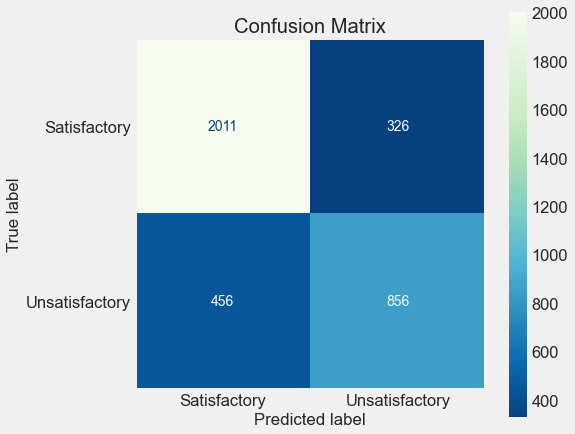

,Accuracy,F1,Recall,Precision
0,0.785695,0.686447,0.652439,0.724196


time: 692 ms


In [103]:
f.confusion_report(best_model, X_test, y_test)

## Final Model Test Score Interpretation:

Upon validation with the test data we see that the model is still having some trouble the minority class, but performance has been improved to a level that is acceptable for our purposes.

- The recall score of .65 indicates that about 65% outcomes were correctly classified as Unsatisfactory.
- The precision score .72 indicates that about 72% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

# Saving Model

In [104]:
# saving the model
# f.pickle_model(best_model, 'final')

time: 581 µs


# F1 Permutation Importances

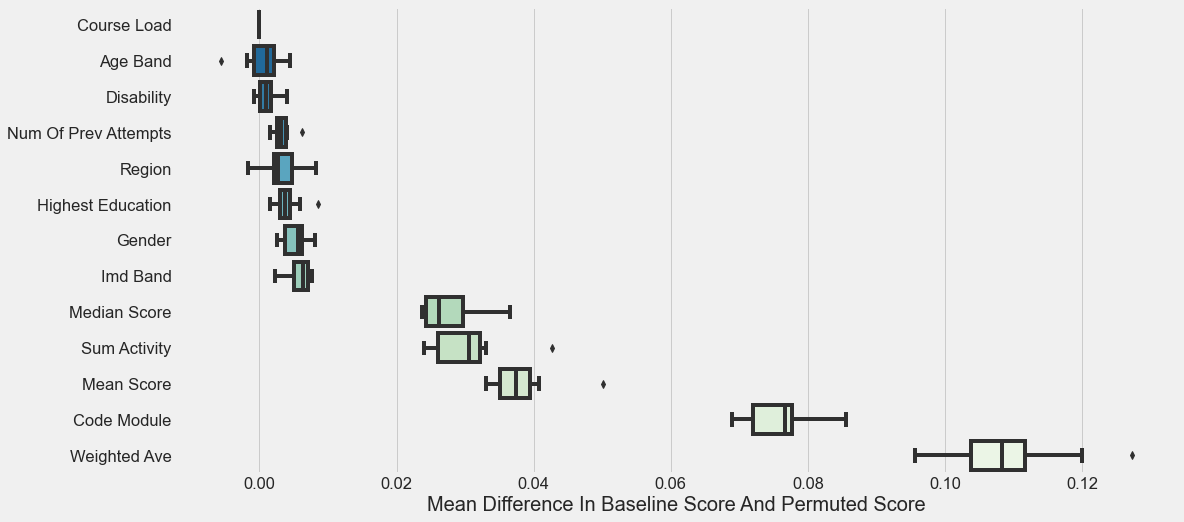

time: 6.83 s


In [105]:
f.perm_importances(best_model, X_test, y_test, 'f1')

The assessment score features (median_score, mean_score & weighted_ave) are the main drivers of the model. Interestingly, some of the most statistically significant features (imd_band, highest_education, and course_load) have little to no effect on the model.

# Validating Model on Holdout Data

### Average Metrics

In [106]:
# checking cross val scores
modeling.report(best_model, X_holdout, y_holdout, 'best_model',\
                'Tuned Voting CLF SS()/SMOTE SOFT HOLDOUT')

best_model has an average Accuracy of 0.7638232271325796
best_model has an average F1 of 0.6529339833140467
best_model has an average Recall of 0.6180679492427343
best_model has an average Precision of 0.6923252894659433
time: 5.7 s


### Holdout Data Confusion Matrix

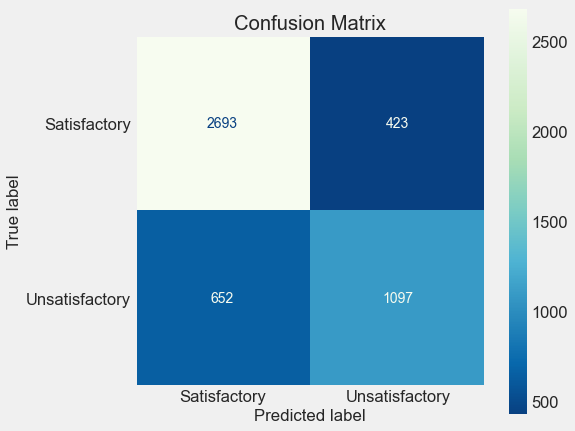

,Accuracy,F1,Recall,Precision
0,0.779034,0.671153,0.627216,0.721711


time: 899 ms


In [107]:
f.confusion_report(best_model, X_holdout, y_holdout)

## Score Interpretation:

Upon validation with the holdout data we see that the model is still having some trouble the minority class, but performance is at a level that is acceptable for our purposes.

- The recall score of .63 indicates that about 63% outcomes were correctly classified as Unsatisfactory.
- The precision score .72 indicates that about 72% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

# ROC AUC

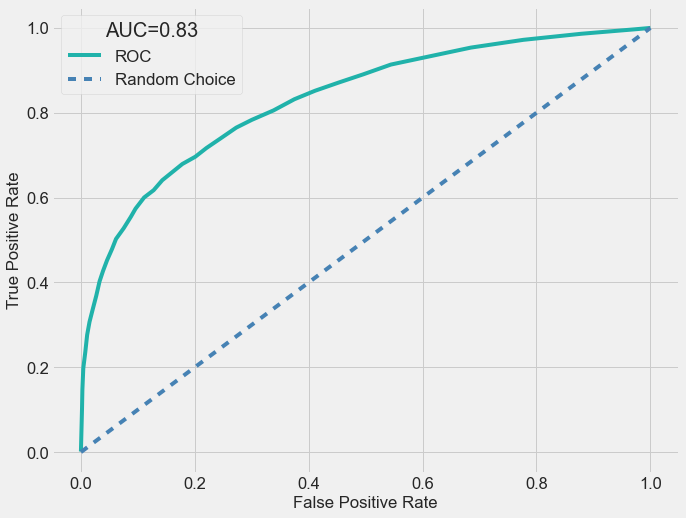

time: 1.16 s


In [108]:
f.roc_auc(best_model, X_holdout, y_holdout)

# Saving The Model Fit on All of the Half-Term Data

In [109]:
# fitting model to all of the data
best_model_full = best_model.fit(X,y)

time: 6.79 s


In [110]:
# saving the model
# f.pickle_model(best_model_full, 'final_full_fit')

time: 590 µs
